# 2. Heart development analysis

Sim, Choon Boon, Belinda Phipson, Mark Ziemann, Haloom Rafehi, Richard J. Mills, Kevin I. Watt, Kwaku D. Abu-Bonsrah, et al. 2021. “Sex-Specific Control of Human Heart Maturation by the Progesterone Receptor.” Circulation 143 (16): 1614–28.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro, run_scanpro
from scanpro.utils import convert_counts_to_df
from scanpro.sim_reps import generate_reps

In [2]:
# Setup path to R
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [3]:
# path where figures are going to be saved
FIG_PATH = 'plots'

-------------

## Read data

In [4]:
heart_counts = pd.read_csv("data/heart_counts.tsv", sep="\t")
heart_counts

,Sample,Condition,Sex,Cardiomyocytes,Endothelial cells,Epicardial cells,Erythroid,Fibroblast,Immune cells,Neurons,Smooth muscle cells
0,f1,Fetal,Male,5475,735,564,43,1029,287,109,54
1,f2,Fetal,Male,8580,715,425,49,755,274,130,20
2,f3,Fetal,Female,5140,1298,404,31,1201,196,110,136
3,y1,Young,Male,1073,511,613,0,1622,337,207,59
4,y2,Young,Female,2221,462,280,0,1688,808,71,28
5,y3,Young,Male,4456,550,260,0,805,731,133,49
6,a1,Adult,Male,1856,599,343,0,1034,449,57,22
7,a2,Adult,Male,564,466,493,0,1230,530,43,49
8,a3,Adult,Male,383,165,92,0,495,519,14,13


In [5]:
heart = convert_counts_to_df(heart_counts, column_name="Celltype")
heart.head()

,Sample,Condition,Sex,Celltype
cell_1,f1,Fetal,Male,Cardiomyocytes
cell_2,f1,Fetal,Male,Cardiomyocytes
cell_3,f1,Fetal,Male,Cardiomyocytes
cell_4,f1,Fetal,Male,Cardiomyocytes
cell_5,f1,Fetal,Male,Cardiomyocytes


-----------

## Run Scanpro

### With replicates

In [6]:
scanpro_out = scanpro(heart, clusters_col='Celltype', conds_col='Condition', samples_col='Sample')
scanpro_out.results.to_csv("results/heart_scanpro_rep_logit.tsv", sep="\t")
scanpro_out.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Cardiomyocytes,0.549464,0.682410,0.426761,0.273547,8.998537,1.235904e-04,3.295744e-04
Endothelial cells,0.101607,0.102108,0.092478,0.124538,0.337551,7.135154e-01,7.135154e-01
Epicardial cells,0.064167,0.051415,0.075410,0.093158,0.901016,4.061567e-01,5.415422e-01
Erythroid,0.002272,0.004433,0.000000,0.000000,197.947461,1.110223e-16,8.881784e-16
Fibroblast,0.182102,0.111342,0.261924,0.298689,4.602496,1.002678e-02,2.005356e-02
Immune cells,0.076302,0.027546,0.108751,0.189588,11.508649,1.004286e-05,4.017142e-05
Neurons,0.016143,0.012643,0.026210,0.011381,1.545816,2.131379e-01,3.410207e-01
Smooth muscle cells,0.007942,0.008102,0.008465,0.009099,0.403828,6.677589e-01,7.135154e-01


In [7]:
scanpro_out = scanpro(heart, clusters_col='Celltype', conds_col='Condition', samples_col='Sample', 
                      transform="arcsin")
scanpro_out.results.to_csv("results/heart_scanpro_rep_arcsin.tsv", sep="\t")
scanpro_out.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Cardiomyocytes,0.549464,0.682410,0.426761,0.273547,6.555778,0.020909,0.055756
Endothelial cells,0.101607,0.102108,0.092478,0.124538,0.942304,0.429422,0.521820
Epicardial cells,0.064167,0.051415,0.075410,0.093158,0.866942,0.456592,0.521820
Erythroid,0.002272,0.004433,0.000000,0.000000,41.640675,0.000063,0.000501
Fibroblast,0.182102,0.111342,0.261924,0.298689,4.822621,0.042666,0.085332
Immune cells,0.076302,0.027546,0.108751,0.189588,9.178229,0.008657,0.034630
Neurons,0.016143,0.012643,0.026210,0.011381,2.240940,0.169327,0.270924
Smooth muscle cells,0.007942,0.008102,0.008465,0.009099,0.082549,0.921548,0.921548


#### With covariate

In [8]:
scanpro_out_cofactor = scanpro(heart, clusters_col='Celltype', conds_col='Condition', samples_col='Sample',
                               covariates="Sex")
scanpro_out_cofactor.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Cardiomyocytes,0.549464,0.682410,0.426761,0.273547,8.304494,2.474025e-04,6.597399e-04
Endothelial cells,0.101607,0.102108,0.092478,0.124538,0.471451,6.240957e-01,6.240957e-01
Epicardial cells,0.064167,0.051415,0.075410,0.093158,0.549832,5.770469e-01,6.240957e-01
Erythroid,0.002272,0.004433,0.000000,0.000000,176.878478,1.110223e-16,8.881784e-16
Fibroblast,0.182102,0.111342,0.261924,0.298689,4.660385,9.462816e-03,1.892563e-02
Immune cells,0.076302,0.027546,0.108751,0.189588,10.094696,4.129800e-05,1.651920e-04
Neurons,0.016143,0.012643,0.026210,0.011381,1.707894,1.812470e-01,2.899952e-01
Smooth muscle cells,0.007942,0.008102,0.008465,0.009099,0.582384,5.585651e-01,6.240957e-01


In [9]:
scanpro_out_cofactor = scanpro(heart, clusters_col='Celltype', conds_col='Condition', samples_col='Sample',
                               covariates="Sex", transform='arcsin')
scanpro_out_cofactor.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,f_statistics,p_values,adjusted_p_values
clusters,,,,,,,
Cardiomyocytes,0.549464,0.682410,0.426761,0.273547,5.988249,0.031625,0.084332
Endothelial cells,0.101607,0.102108,0.092478,0.124538,1.547499,0.279307,0.372409
Epicardial cells,0.064167,0.051415,0.075410,0.093158,0.509690,0.621927,0.710773
Erythroid,0.002272,0.004433,0.000000,0.000000,40.221067,0.000170,0.001362
Fibroblast,0.182102,0.111342,0.261924,0.298689,5.042671,0.045375,0.090750
Immune cells,0.076302,0.027546,0.108751,0.189588,7.848449,0.017101,0.068405
Neurons,0.016143,0.012643,0.026210,0.011381,2.893398,0.123234,0.197174
Smooth muscle cells,0.007942,0.008102,0.008465,0.009099,0.166661,0.849840,0.849840


### Scanpro without replicates

In [10]:
# logit
scanpro_out_norep = scanpro(heart, clusters_col='Celltype', conds_col='Condition')
scanpro_out_norep.results.to_csv("results/heart_scanpro_norep_logit.tsv", sep="\t")
scanpro_out_norep.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 12.39 seconds


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,p_values
clusters,,,,,
Cardiomyocytes,0.549464,0.692790,0.455183,0.290838,0.003070
Endothelial cells,0.101607,0.100384,0.082951,0.129832,0.347790
Epicardial cells,0.064167,0.046936,0.064376,0.097898,0.231036
Erythroid,0.002272,0.003353,0.000000,0.000000,0.003267
Fibroblast,0.182102,0.098264,0.235793,0.289614,0.027307
Immune cells,0.076302,0.023209,0.104477,0.152232,0.009750
Neurons,0.016143,0.010659,0.022013,0.009810,0.509621
Smooth muscle cells,0.007942,0.006050,0.006348,0.008041,0.710827


In [11]:
# arcsin
scanpro_out_norep = scanpro(heart, clusters_col='Celltype', conds_col='Condition', transform="arcsin")
scanpro_out_norep.results.to_csv("results/heart_scanpro_norep_arcsin.tsv", sep="\t")
scanpro_out_norep.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 12.1 seconds


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,p_values
clusters,,,,,
Cardiomyocytes,0.549464,0.692790,0.455183,0.290838,0.000040
Endothelial cells,0.101607,0.100384,0.082951,0.129832,0.243245
Epicardial cells,0.064167,0.046936,0.064376,0.097898,0.127428
Erythroid,0.002272,0.003353,0.000000,0.000000,0.026868
Fibroblast,0.182102,0.098264,0.235793,0.289614,0.002783
Immune cells,0.076302,0.023209,0.104477,0.152232,0.000752
Neurons,0.016143,0.010659,0.022013,0.009810,0.334487
Smooth muscle cells,0.007942,0.006050,0.006348,0.008041,0.631939


#### With covariate

In [12]:
# with covariate
scanpro_out_norep_cofactor = scanpro(heart, clusters_col='Celltype',
                                conds_col='Condition', transform="logit", covariates="Sex")
scanpro_out_norep_cofactor.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 14.77 seconds


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,p_values
clusters,,,,,
Cardiomyocytes,0.549464,0.692817,0.455168,0.300256,0.007174
Endothelial cells,0.101607,0.098159,0.085666,0.126394,0.399107
Epicardial cells,0.064167,0.045047,0.065764,0.095992,0.350891
Erythroid,0.002272,0.002937,0.000000,0.000000,0.004497
Fibroblast,0.182102,0.104651,0.240401,0.284394,0.048001
Immune cells,0.076302,0.023101,0.105361,0.153608,0.017012
Neurons,0.016143,0.010028,0.021859,0.009946,0.400525
Smooth muscle cells,0.007942,0.005384,0.006639,0.007211,0.641348


In [13]:
# with covariate
scanpro_out_norep_cofactor = scanpro(heart, clusters_col='Celltype',
                                conds_col='Condition', transform="arcsin", covariates="Sex")
scanpro_out_norep_cofactor.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 14.92 seconds


,baseline_props,mean_props_Fetal,mean_props_Young,mean_props_Adult,p_values
clusters,,,,,
Cardiomyocytes,0.549464,0.692817,0.455168,0.300256,0.000075
Endothelial cells,0.101607,0.098159,0.085666,0.126394,0.268581
Epicardial cells,0.064167,0.045047,0.065764,0.095992,0.180828
Erythroid,0.002272,0.002937,0.000000,0.000000,0.069199
Fibroblast,0.182102,0.104651,0.240401,0.284394,0.007100
Immune cells,0.076302,0.023101,0.105361,0.153608,0.001168
Neurons,0.016143,0.010028,0.021859,0.009946,0.277770
Smooth muscle cells,0.007942,0.005384,0.006639,0.007211,0.581406


### Plots

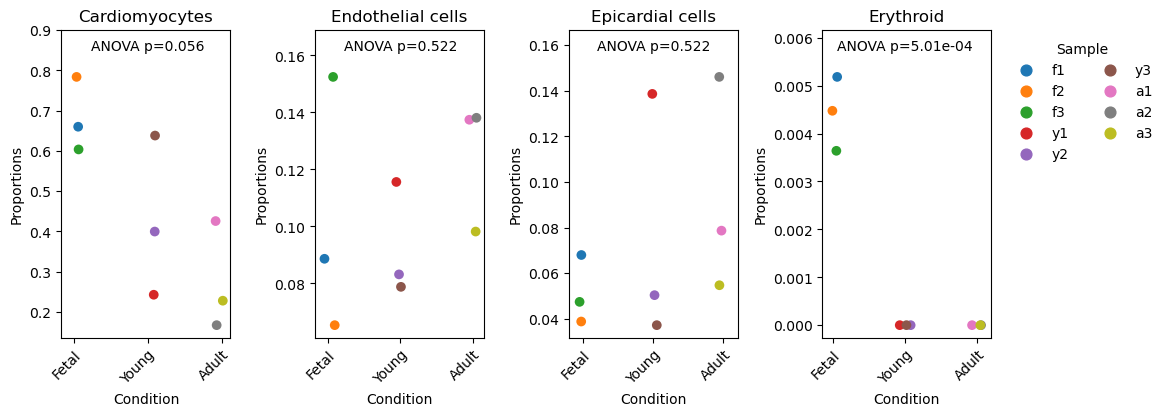

In [14]:
# original samples
scanpro_out.plot(n_columns=4, clusters=['Cardiomyocytes','Endothelial cells','Epicardial cells','Erythroid'],
                 save=f'{FIG_PATH}/heart_stripplot.pdf')

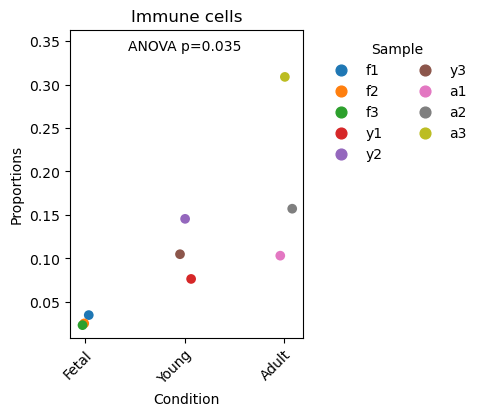

In [15]:
# original samples
scanpro_out.plot(n_columns=4, clusters=['Immune cells'])

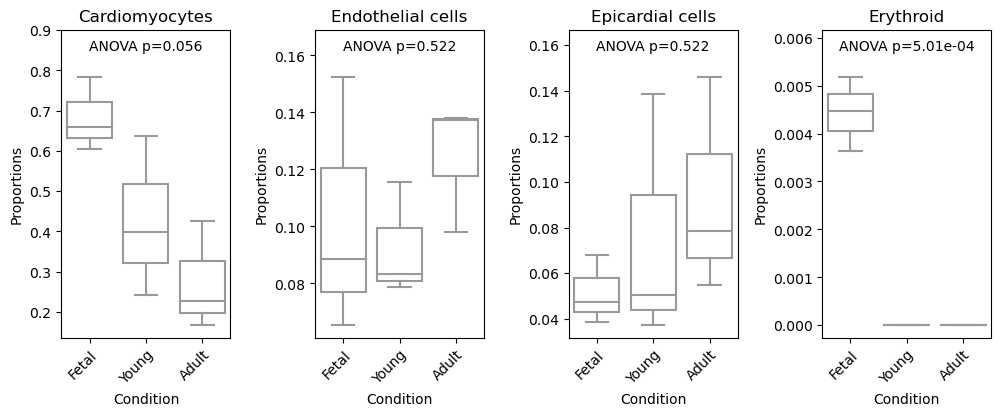

In [16]:
scanpro_out.plot(kind='boxplot', n_columns=4, clusters=['Cardiomyocytes','Endothelial cells',
                                                        'Epicardial cells','Erythroid'],
                 save=f'{FIG_PATH}/heart_boxplot.pdf')

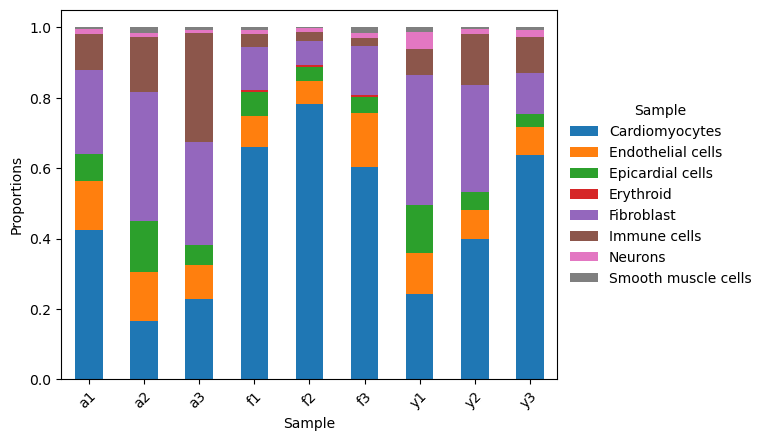

In [17]:
scanpro_out.plot_samples(save=f"{FIG_PATH}/heart_sample_barplot.pdf")

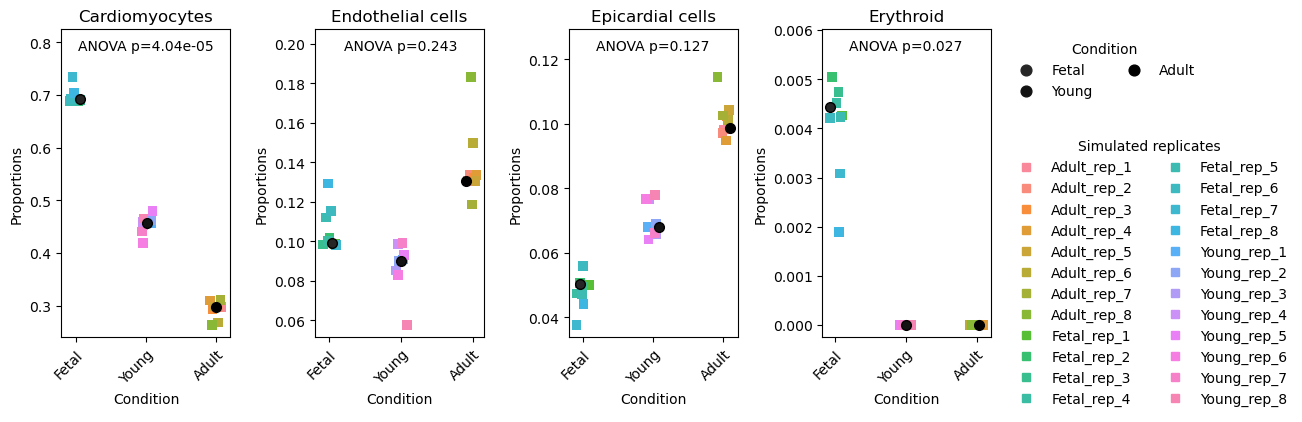

In [18]:
# Simulated replicates
scanpro_out_norep.plot(n_columns=4, clusters=['Cardiomyocytes','Endothelial cells','Epicardial cells','Erythroid'],
                       save=f'{FIG_PATH}/heart_norep_stripplot.pdf')

---------------------

## Propeller

In [19]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
%%R -i heart -o propeller_results_logit -o propeller_results_arcsin
library(speckle)

propeller_results_logit = propeller(clusters = heart$Celltype, sample = heart$Sample, group = heart$Condition, transform="logit")
propeller_results_arcsin = propeller(clusters = heart$Celltype, sample = heart$Sample, group = heart$Condition, transform="asin")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Performing logit transformation of proportions
group variable has > 2 levels, ANOVA will be performed
Performing arcsin square root transformation of proportions
group variable has > 2 levels, ANOVA will be performed


In [21]:
propeller_results_logit

,BaselineProp,PropMean.Adult,PropMean.Fetal,PropMean.Young,Fstatistic,P.Value,FDR
Erythroid,0.002272,-0.000000,0.004433,-0.000000,46.591998,5.825757e-21,4.660605e-20
Immune cells,0.076302,0.189588,0.027546,0.108751,11.575093,9.397256e-06,3.758902e-05
Cardiomyocytes,0.549464,0.273547,0.682410,0.426761,9.068229,1.152704e-04,3.073879e-04
Fibroblast,0.182102,0.298689,0.111342,0.261924,4.630794,9.747019e-03,1.949404e-02
Neurons,0.016143,0.011381,0.012643,0.026210,1.519245,2.188770e-01,3.502033e-01
Epicardial cells,0.064167,0.093158,0.051415,0.075410,0.909787,4.026099e-01,5.368133e-01
Smooth muscle cells,0.007942,0.009099,0.008102,0.008465,0.421692,6.559362e-01,7.117040e-01
Endothelial cells,0.101607,0.124538,0.102108,0.092478,0.340093,7.117040e-01,7.117040e-01


In [22]:
propeller_results_logit.to_csv("results/heart_propeller_rep_logit.tsv", sep="\t")
propeller_results_arcsin.to_csv("results/heart_propeller_rep_arcsin.tsv", sep="\t")

------------

## scCODA

In [23]:
import pertpy as pt
import anndata as ad

### Data preparation

In [24]:
sccoda_adata = ad.AnnData(obs=heart)

### With replicates

In [25]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="Celltype", 
                                sample_identifier="Sample", covariate_obs=["Condition"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Condition")

Automatic reference selection! Reference cell type set to Smooth muscle cells

Zero counts encountered in data! Added a pseudocount of 0.5.

In [26]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [01:22<00:00, 134.07it/s, 255 steps of size 1.70e-02. acc. prob=0.89]


In [27]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 9 samples, 8 cell types                                    │
│ Reference cell type                          │ Smooth muscle cells                                              │
│ Formula                                      │ Condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Expected Sample                                                           │
│ Cell Type                                                                                                       │
│ Cardiomyocytes            2.396          1865.024                                                               │
│ Endothelial cells         1.532           786.057                                                               │
│ Epicardial cells          1.193           560.052                                                               │
│ Erythroid                -1.561            35.660                                                               │
│ Fibroblast                2.268          1640.948                                                               │
│ Immune cells              1.597           838.848                                                               │
│ Neurons                   0.004           170.550                                                               │
│ Smooth muscle cells      -0.358           118.751                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                Final Parameter  Expected Sample  log2-fold change                               │
│ Covariate Cell Type                                                                                             │
│ T.Fetal   Cardiomyocytes           1.515           4039.104            1.115                                    │
│           Endothelial cells        0.000            374.347           -1.070                                    │
│           Epicardial cells         0.000            266.716           -1.070                                    │
│           Erythroid                0.000             16.983           -1.070                                    │
│           Fibroblast               0.000            781.476           -1.070                                    │
│           Immune cells             0.000            399.488           -1.070                                    │
│           Neurons                  0.000             81.222           -1.070                                    │
│           Smooth muscle cells      0.000             56.553           -1.070                                    │
│ T.Young   Cardiomyocytes           0.000           1865.024            0.000                                    │
│           Endothelial cells        0.000            786.057            0.000                                    │
│           Epicardial cells         0.000            560.052            0.000                                    │
│           Erythroid                0.000             35.660            0.000                                    │
│           Fibroblast               0.000           1640.948            0.000                                    │
│           Immune cells             0.000            838.848            0.000                                    │
│           Neurons                  0.000            170.550            0.000                                    │
│           Smooth muscle cells      0.000            118.751            0.000                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [28]:
# Get credible effects at different FDR levels:
credible_effects_list = []
for fdr in [0.01,0.05,0.1,0.2,0.3,0.4]:
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=fdr)
    
    credible_effects_table = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
    credible_effects_table["fdr"] = fdr
    credible_effects_list.append(credible_effects_table)

credible_effects = pd.concat(credible_effects_list)
credible_effects

credible_effect   fdr
Covariate          Cell Type                                 
Condition[T.Fetal] Cardiomyocytes                  True  0.01
                   Endothelial cells              False  0.01
                   Epicardial cells               False  0.01
                   Erythroid                      False  0.01
                   Fibroblast                     False  0.01
...                                                 ...   ...
Condition[T.Young] Erythroid                       True  0.40
                   Fibroblast                      True  0.40
                   Immune cells                    True  0.40
                   Neurons                         True  0.40
                   Smooth muscle cells            False  0.40

[96 rows x 2 columns]

In [29]:
credible_effects.to_csv("results/heart_sccoda_rep.tsv", sep="\t")

### Without replicates

In [30]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="Celltype", 
                                sample_identifier="Condition", covariate_obs=["Condition"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Condition")

Automatic reference selection! Reference cell type set to Smooth muscle cells

Zero counts encountered in data! Added a pseudocount of 0.5.

In [31]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [00:59<00:00, 184.16it/s, 511 steps of size 1.04e-02. acc. prob=0.93]


In [32]:
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 3 samples, 8 cell types                                    │
│ Reference cell type                          │ Smooth muscle cells                                              │
│ Formula                                      │ Condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                      Final Parameter  Expected Sample                                                           │
│ Cell Type                                                                                                       │
│ Cardiomyocytes            4.204          5951.689                                                               │
│ Endothelial cells         3.253          2299.462                                                               │
│ Epicardial cells          2.903          1620.403                                                               │
│ Erythroid                -1.311            23.961                                                               │
│ Fibroblast                4.046          5081.848                                                               │
│ Immune cells              3.342          2513.497                                                               │
│ Neurons                   1.350           342.897                                                               │
│ Smooth muscle cells       0.875           213.243                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                Final Parameter  Expected Sample  log2-fold change                               │
│ Covariate Cell Type                                                                                             │
│ T.Fetal   Cardiomyocytes           1.226          11304.960            0.926                                    │
│           Endothelial cells        0.000           1281.741           -0.843                                    │
│           Epicardial cells         0.000            903.228           -0.843                                    │
│           Erythroid                0.000             13.356           -0.843                                    │
│           Fibroblast               0.000           2832.670           -0.843                                    │
│           Immune cells             0.000           1401.047           -0.843                                    │
│           Neurons                  0.000            191.134           -0.843                                    │
│           Smooth muscle cells      0.000            118.863           -0.843                                    │
│ T.Young   Cardiomyocytes           0.000           5951.689            0.000                                    │
│           Endothelial cells        0.000           2299.462            0.000                                    │
│           Epicardial cells         0.000           1620.403            0.000                                    │
│           Erythroid                0.000             23.961            0.000                                    │
│           Fibroblast               0.000           5081.848            0.000                                    │
│           Immune cells             0.000           2513.497            0.000                                    │
│           Neurons                  0.000            342.897            0.000                                    │
│           Smooth muscle cells      0.000            213.243            0.000                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [33]:
# Get credible effects at different FDR levels:
credible_effects_list = []
for fdr in [0.01,0.05,0.1,0.2,0.3,0.4]:
    sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=fdr)
    
    credible_effects_table = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
    credible_effects_table["fdr"] = fdr
    credible_effects_list.append(credible_effects_table)

credible_effects = pd.concat(credible_effects_list)
credible_effects

credible_effect   fdr
Covariate          Cell Type                                 
Condition[T.Fetal] Cardiomyocytes                 False  0.01
                   Endothelial cells              False  0.01
                   Epicardial cells               False  0.01
                   Erythroid                      False  0.01
                   Fibroblast                     False  0.01
...                                                 ...   ...
Condition[T.Young] Erythroid                       True  0.40
                   Fibroblast                     False  0.40
                   Immune cells                    True  0.40
                   Neurons                         True  0.40
                   Smooth muscle cells            False  0.40

[96 rows x 2 columns]

In [34]:
credible_effects.to_csv("results/heart_sccoda_norep.tsv", sep="\t")